In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import sys
import warnings
warnings.filterwarnings("ignore")
import random
import matplotlib.pyplot as plt
sys.path.insert(1, '/home/wangc90/Data_integration/MOCSS/mocss/code/')
import evaluation
from Data_prep import DataSet_Prep, DataSet_construction
from tsn_visulization import tsn_data, tsn_plot
random.seed(2023)
torch.manual_seed(2023)

In [3]:
class SSO2_Encoder(nn.Module):
    """
        takes in 3 omic data type measurements for the same set of subjects
    """
    
    def __init__(self):
        
        
        
        ### input dimension for omic 1, omic 2 and omic 3
        self.s1_input_dim = 20531
        self.s2_input_dim = 1046
        
        self.l1_s1_out_dim = 128
        self.l1_s2_out_dim = 64
        self.l1_s12_out_dim = 64
        
        
        self.l2_s1_out_dim = 256
        self.l2_s2_out_dim = 512
        self.l2_s12_out_dim = 256

        
        self.l3_s1_out_dim = 1024
        self.l3_s2_out_dim = 32
        self.l3_s12_out_dim = 64
        
        ### embedding for z1, z2 and z12 have to have the same dimension for the 
        ### orthogonal losss based on MOCSS to work
        self.embed_s1_out_dim = 1024
        self.embed_s2_out_dim = self.embed_s1_out_dim
        self.embed_s12_out_dim = self.embed_s1_out_dim
        
        
        
        super(SSO2_Encoder, self).__init__()
        
        ### encoder structure: 
        
        ######################################################################################
        self.l1_s1 = nn.Linear(self.s1_input_dim, self.l1_s1_out_dim)
        self.l1_s1_bn = nn.BatchNorm1d(self.l1_s1_out_dim)
        l1_s1_drop_rate = 0
        self.drop_l1_s1 = nn.Dropout(p=l1_s1_drop_rate)
        
        
        self.l2_s1 = nn.Linear(self.l1_s1_out_dim,  self.l2_s1_out_dim)
        self.l2_s1_bn = nn.BatchNorm1d(self.l2_s1_out_dim)
        l2_s1_drop_rate = 0.1
        self.drop_l2_s1 = nn.Dropout(p=l2_s1_drop_rate)
        
        
        self.l3_s1 = nn.Linear(self.l2_s1_out_dim, self.l3_s1_out_dim)
        self.l3_s1_bn = nn.BatchNorm1d(self.l3_s1_out_dim)
        l3_s1_drop_rate = 0.1
        self.drop_l3_s1 = nn.Dropout(p=l3_s1_drop_rate)
        
        
        self.embed_s1 = nn.Linear(self.l3_s1_out_dim, self.embed_s1_out_dim)
        self.embed_s1_bn = nn.BatchNorm1d(self.embed_s1_out_dim)
        embed_s1_drop_rate = 0
        self.drop_embed_s1 = nn.Dropout(p=embed_s1_drop_rate)
        
        
        ###########################################################################################
        self.l1_s2 = nn.Linear(self.s2_input_dim, self.l1_s2_out_dim)
        self.l1_s2_bn = nn.BatchNorm1d(self.l1_s2_out_dim)
        l1_s2_drop_rate = 0.4
        self.drop_l1_s2 = nn.Dropout(p=l1_s2_drop_rate)
        
        
        self.l2_s2 = nn.Linear(self.l1_s2_out_dim,  self.l2_s2_out_dim)
        self.l2_s2_bn = nn.BatchNorm1d(self.l2_s2_out_dim)
        l2_s2_drop_rate = 0.2
        self.drop_l2_s2 = nn.Dropout(p=l2_s2_drop_rate)
        
        
        self.l3_s2 = nn.Linear(self.l2_s2_out_dim, self.l3_s2_out_dim)
        self.l3_s2_bn = nn.BatchNorm1d(self.l3_s2_out_dim)
        l3_s2_drop_rate = 0.4
        self.drop_l3_s2 = nn.Dropout(p=l3_s2_drop_rate)
        
        
        self.embed_s2 = nn.Linear(self.l3_s2_out_dim, self.embed_s2_out_dim)
        self.embed_s2_bn = nn.BatchNorm1d(self.embed_s2_out_dim)
        embed_s2_drop_rate = 0.2
        self.drop_embed_s2 = nn.Dropout(p=embed_s2_drop_rate)
        
        
        
        ##########################################################################################
        
        self.l1_s12 = nn.Linear(self.s1_input_dim + self.s2_input_dim,
                                 self.l1_s12_out_dim)
        self.l1_s12_bn = nn.BatchNorm1d(self.l1_s12_out_dim)
        l1_s12_drop_rate = 0.6
        self.drop_l1_s12 = nn.Dropout(p=l1_s12_drop_rate)
        
        
        self.l2_s12 = nn.Linear(self.l1_s12_out_dim,  self.l2_s12_out_dim)
        self.l2_s12_bn = nn.BatchNorm1d(self.l2_s12_out_dim)
        l2_s12_drop_rate = 0.6
        self.drop_l2_s12 = nn.Dropout(p=l2_s12_drop_rate)
        
        
        self.l3_s12 = nn.Linear(self.l2_s12_out_dim, self.l3_s12_out_dim)
        self.l3_s12_bn = nn.BatchNorm1d(self.l3_s12_out_dim)
        l3_s12_drop_rate = 0.6
        self.drop_l3_s12 = nn.Dropout(p=l3_s12_drop_rate)
        
        
        self.embed_s12 = nn.Linear(self.l3_s12_out_dim, self.embed_s12_out_dim)
        self.embed_s12_bn = nn.BatchNorm1d(self.embed_s12_out_dim)
        embed_s12_drop_rate = 0.6
        self.drop_embed_s12 = nn.Dropout(p=embed_s12_drop_rate)
        

    def forward(self, s1, s2, labels=None):
        
        #############################################################
        s1_ = self.drop_l1_s1(self.l1_s1_bn(F.relu(self.l1_s1(s1))))
        s1_ = self.drop_l2_s1(self.l2_s1_bn(F.relu(self.l2_s1(s1_))))
        s1_ = self.drop_l3_s1(self.l3_s1_bn(F.relu(self.l3_s1(s1_))))
        z1 = self.drop_embed_s1(self.embed_s1_bn(F.relu(self.embed_s1(s1_))))
        
        
        
        s2_ = self.drop_l1_s2(self.l1_s2_bn(F.relu(self.l1_s2(s2))))
        s2_ = self.drop_l2_s2(self.l2_s2_bn(F.relu(self.l2_s2(s2_))))
        s2_ = self.drop_l3_s2(self.l3_s2_bn(F.relu(self.l3_s2(s2_))))
        z2 = self.drop_embed_s2(self.embed_s2_bn(F.relu(self.embed_s2(s2_))))
        
        
        
        
        ### concatenate s1, s2 together for the joint embedding
        s12 = torch.cat((s1, s2), dim=1)
        s12_ = self.drop_l1_s12(self.l1_s12_bn(F.relu(self.l1_s12(s12))))
        s12_ = self.drop_l2_s12(self.l2_s12_bn(F.relu(self.l2_s12(s12_))))
        s12_ = self.drop_l3_s12(self.l3_s12_bn(F.relu(self.l3_s12(s12_))))
        z12 = self.drop_embed_s12(self.embed_s12_bn(F.relu(self.embed_s12(s12_))))
        
        
        return z1, z2, z12, labels
    
    

class SSO2_Decoder(nn.Module):
    
    ### decoder: construct s1 and s2  based on the concatenated z12 z1 and z2
    ### and calculate the reconstruction loss separately for s1 and s2
    
    def __init__(self):
        
        
        
        self.s1_input_dim = SSO2_Encoder().s1_input_dim
        self.s2_input_dim = SSO2_Encoder().s2_input_dim
        
        self.s1_embed_dim = SSO2_Encoder().embed_s1_out_dim
        self.s2_embed_dim = SSO2_Encoder().embed_s2_out_dim
        self.s12_embed_dim = SSO2_Encoder().embed_s12_out_dim
        
        
        self._embed_s1_out_dim = 256
        self._l3_s1_out_dim = 256
        self._l2_s1_out_dim = 1024
        self._l1_s1_out_dim = self.s1_input_dim
        
        
        self._embed_s2_out_dim = 512
        self._l3_s2_out_dim = 32
        self._l2_s2_out_dim = 256
        self._l1_s2_out_dim = self.s2_input_dim
        
        
        super(SSO2_Decoder, self).__init__()
        
        
        self._embed_s1 = nn.Linear(self.s1_embed_dim + self.s2_embed_dim + self.s12_embed_dim,\
                                   self._embed_s1_out_dim)
        
        self._embed_s1_bn = nn.BatchNorm1d(self._embed_s1_out_dim)
        _embed_s1_drop_rate = 0.2
        self._drop_embed_s1 = nn.Dropout(p=_embed_s1_drop_rate)
        
        
        self._l3_s1 = nn.Linear(self._embed_s1_out_dim, self._l3_s1_out_dim)
        self._l3_s1_bn = nn.BatchNorm1d(self._l3_s1_out_dim)
        _l3_s1_drop_rate = 0
        self._drop_l3_s1 = nn.Dropout(p=_l3_s1_drop_rate)
        
        
        self._l2_s1 = nn.Linear(self._l3_s1_out_dim, self._l2_s1_out_dim)
        self._l2_s1_bn = nn.BatchNorm1d(self._l2_s1_out_dim)
        _l2_s1_drop_rate = 0.6
        self._drop_l2_s1 = nn.Dropout(p=_l2_s1_drop_rate)
        
        
        self._l1_s1 = nn.Linear(self._l2_s1_out_dim, self._l1_s1_out_dim)
        self._l1_s1_bn = nn.BatchNorm1d(self._l1_s1_out_dim)
        _l1_s1_drop_rate = 0
        self._drop_l1_s1 = nn.Dropout(p=_l1_s1_drop_rate)
        
        #############################################################################

        self._embed_s2 = nn.Linear(self.s1_embed_dim + self.s2_embed_dim + self.s12_embed_dim,\
                                   self._embed_s2_out_dim)
        
        self._embed_s2_bn = nn.BatchNorm1d(self._embed_s2_out_dim)
        _embed_s2_drop_rate = 0.1
        self._drop_embed_s2 = nn.Dropout(p=_embed_s2_drop_rate)
        
        
        self._l3_s2 = nn.Linear(self._embed_s2_out_dim, self._l3_s2_out_dim)
        self._l3_s2_bn = nn.BatchNorm1d(self._l3_s2_out_dim)
        _l3_s2_drop_rate = 0.1
        self._drop_l3_s2 = nn.Dropout(p=_l3_s2_drop_rate)
        
        
        self._l2_s2 = nn.Linear(self._l3_s2_out_dim, self._l2_s2_out_dim)
        self._l2_s2_bn = nn.BatchNorm1d(self._l2_s2_out_dim)
        _l2_s2_drop_rate = 0.1
        self._drop_l2_s2 = nn.Dropout(p=_l2_s2_drop_rate)
        
        
        self._l1_s2 = nn.Linear(self._l2_s2_out_dim, self._l1_s2_out_dim)
        self._l1_s2_bn = nn.BatchNorm1d(self._l1_s2_out_dim)
        _l1_s2_drop_rate = 0
        self._drop_l1_s2 = nn.Dropout(p=_l1_s2_drop_rate)
        
        
        
    def forward(self, z1, z2, z12):
        
        z_all = torch.cat((z1, z2, z12), dim=1)
        
        
        s1_ = self._drop_embed_s1(self._embed_s1_bn(F.relu(self._embed_s1(z_all))))
        s1_ = self._drop_l3_s1(self._l3_s1_bn(F.relu(self._l3_s1(s1_))))
        s1_ = self._drop_l2_s1(self._l2_s1_bn(F.relu(self._l2_s1(s1_))))
        s1_ = self._drop_l1_s1(self._l1_s1_bn(F.relu(self._l1_s1(s1_))))
        
        s1_out = torch.sigmoid(s1_)
        
        
        
        s2_ = self._drop_embed_s2(self._embed_s2_bn(F.relu(self._embed_s2(z_all))))
        
        s2_ = self._drop_l3_s2(self._l3_s2_bn(F.relu(self._l3_s2(s2_))))
        s2_ = self._drop_l2_s2(self._l2_s2_bn(F.relu(self._l2_s2(s2_))))
        s2_ = self._drop_l1_s2(self._l1_s2_bn(F.relu(self._l1_s2(s2_))))
        
        s2_out = torch.sigmoid(s2_)
        
        return s1_out, s2_out

    
class SSO2_AE(nn.Module):
    def __init__(self):
        
        super(SSO2_AE, self).__init__()
        
        self.encoder = SSO2_Encoder()
        self.decoder = SSO2_Decoder()

    def forward(self, s1, s2, labels):
        
        ### encoder ouput for embeddings
        z1, z2, z12, labels = self.encoder(s1, s2, labels)
        
        ### decoder output for reconstructed input
        s1_out, s2_out = self.decoder(z1, z2, z12)
        
        return z1, z2, z12, s1_out, s2_out, labels

In [4]:
SSO2_AE()

SSO2_AE(
  (encoder): SSO2_Encoder(
    (l1_s1): Linear(in_features=20531, out_features=128, bias=True)
    (l1_s1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_l1_s1): Dropout(p=0, inplace=False)
    (l2_s1): Linear(in_features=128, out_features=256, bias=True)
    (l2_s1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_l2_s1): Dropout(p=0.1, inplace=False)
    (l3_s1): Linear(in_features=256, out_features=1024, bias=True)
    (l3_s1_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_l3_s1): Dropout(p=0.1, inplace=False)
    (embed_s1): Linear(in_features=1024, out_features=1024, bias=True)
    (embed_s1_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_embed_s1): Dropout(p=0, inplace=False)
    (l1_s2): Linear(in_features=1046, out_features=64, bias=True)
    (l1_s2_bn): BatchNorm1d(64, eps=1e-05,

In [5]:
def CustomLoss(s1, s2, s1_out, s2_out,
               z1, z2, z12, labels):
    """
        Ortho_AE2
    """

    ### normalize the feature vector with length 1
    s1_out = F.normalize(s1_out, p=2, dim=1)
    s2_out = F.normalize(s2_out, p=2, dim=1)

    s1 = F.normalize(s1, p=2, dim=1)
    s2 = F.normalize(s2, p=2, dim=1)

    recon_loss = torch.linalg.matrix_norm(s1_out - s1) + torch.linalg.matrix_norm(s2_out - s2)

    z1 = F.normalize(z1, p=2, dim=1)
    z2 = F.normalize(z2, p=2, dim=1)
    z12 = F.normalize(z12, p=2, dim=1)

    z1_t = torch.t(z1)
    z2_t = torch.t(z2)

    z12_z1_t = torch.matmul(z12, z1_t)
    z12_z2_t = torch.matmul(z12, z2_t)
    #     z2_z1_t = torch.matmul(z2, z1_t)

    #### shared and specific
    z12_z1_t_diag = torch.diagonal(z12_z1_t, 0)  ## get the main diagnol
    z12_z1_t_diag_square_sum = torch.sum(
        torch.square(z12_z1_t_diag))  ## get squared term to make it close to 0 in magnitude

    z12_z2_t_diag = torch.diagonal(z12_z2_t, 0)  ## get the main diagnol
    z12_z2_t_diag_square_sum = torch.sum(
        torch.square(z12_z2_t_diag))  ## get squared term to make it close to 0 in magnitude

    ### between two specific
    #     z2_z1_t_diag = torch.diagonal(z2_z1_t, 0) ## get the main diagnol
    #     z2_z1_t_diag_square_sum = torch.sum(torch.square(z2_z1_t_diag)) ## get squared term to make it close to 0 in magnitude

    ortho_loss = z12_z1_t_diag_square_sum + z12_z2_t_diag_square_sum  # + z2_z1_t_diag_square_sum

    return recon_loss, ortho_loss

In [6]:
### assuming all the hyperparameters are optimized by Optuna and then retrain the model on the entire training set

def retraining(model, dataset, model_folder):
    
    train_recon_loss_ = []

    device = torch.device('cuda:1') if torch. cuda.is_available() else torch.device('cpu')
    
    batch_size = 256
    
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     print(len(train_loader))
    
    model = model().to(device=device)
#     print(model)
    
    
    optimizer_name = 'Adam'
    lr = 0.0066396817176637745
    l2_lambda = 1.1942645411521186e-08
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=l2_lambda)
    
    ortho_multiplier = 100.0
    epochs = 120 ### reduce the epochs from 150 to 100 to reduce the potential overfitting
    
    for epoch in range(epochs):
        #         print(f"I'am in the epoch {epoch}")
        model.train()
        # record the training loss
        total_recon_loss = 0.0
        total_train = 0.0

        ## deal with different number of features in different dataset with star* notation
        for view1_train_data, view2_train_data, train_labels in train_loader:
            ### this line is just for nn.CrossEntropy loss otherwise can be safely removed
            view1_train_data = view1_train_data.type(torch.float32).to(device)
            view2_train_data = view2_train_data.type(torch.float32).to(device)
            train_labels = train_labels.type(torch.LongTensor).to(device)

            z1, z2, z12, s1_out, s2_out, labels = \
            model(view1_train_data, view2_train_data, train_labels)
            
            train_size = z12.size()[0]
    
            recon_loss, ortho_loss = CustomLoss(s1=view1_train_data,\
                                             s2=view2_train_data,\
                                             s1_out=s1_out,\
                                             s2_out=s2_out,\
                                             z1=z1,\
                                             z2=z2,\
                                             z12=z12,\
                                             labels=train_labels)
        
            loss = recon_loss + (ortho_loss * ortho_multiplier)

            # backward pass
            optimizer.zero_grad()  # empty the gradient from last round

            # calculate the gradient
            loss.backward()
            # update the parameters
            optimizer.step()
            
            total_train += train_size
            
            total_recon_loss += recon_loss.item()
    
        train_recon_loss_.append(total_recon_loss / total_train)
        
        if (epoch+1) % 10 == 0:
            print(f'finished retraining on epoch: {epoch}')
    # save the model at the end of 150 epochs
    model_path = f"{model_folder}/retrained_model_{epoch}.pt"
    
    torch.save(model, model_path)
    
    return train_recon_loss_


In [7]:
def Ortho_retraining():
    ### where to save the 3-fold CV validation acc

    ### where to save the retrained model
    model_folder = '/home/wangc90/Data_integration/TCGA_model_outputs/model_retraining_outputs/Ortho_AE_2_retraining'

    combined_exp_df = pd.read_csv('/home/wangc90/Data_integration/TCGA_data/TCGA_primary_tumor_data/combined_exp_df.csv', sep='\t')
    combined_miRNA_df = pd.read_csv('/home/wangc90/Data_integration/TCGA_data/TCGA_primary_tumor_data/combined_miRNA_df.csv', sep='\t')

    labels = pd.read_csv('/home/wangc90/Data_integration/TCGA_data/TCGA_primary_tumor_data/labels.csv', sep='\t')['0']

    dataset_prep = DataSet_Prep(data1=combined_exp_df, data2=combined_miRNA_df, label=labels, training_prop=0.8)

    train_key, test_key = dataset_prep.get_train_test_keys()

    feature1_tensors, feature2_tensors, label_tensors = dataset_prep.to_tensor(train_key)
    

    train_dataset = DataSet_construction(feature1_tensors, feature2_tensors, label_tensors)

    print(len(train_dataset))

    train_recon_loss_ = retraining(model=SSO2_AE, dataset=train_dataset,model_folder=model_folder)
    
    return train_recon_loss_

In [8]:
train_recon_loss_ = Ortho_retraining()

feature1 and feature2 are being scaled with MinMaxScaler
1494
finished retraining on epoch: 9
finished retraining on epoch: 19
finished retraining on epoch: 29
finished retraining on epoch: 39
finished retraining on epoch: 49
finished retraining on epoch: 59
finished retraining on epoch: 69
finished retraining on epoch: 79
finished retraining on epoch: 89
finished retraining on epoch: 99
finished retraining on epoch: 109
finished retraining on epoch: 119


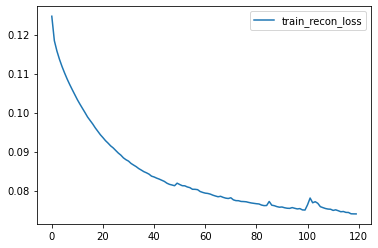

In [9]:
plt.figure()
plt.plot(train_recon_loss_, label='train_recon_loss')
plt.legend()
plt.show()